# Electrode Classifier

### This notebook contains an example of training a model built on ResNet18 to predict whether an image contains a cathode, anode, or neither.

#### Plotting Functionality:
- **Display training and testing loss and accuracy per epoch**
- **Evaluate the trained model on a dataset of your choosing**
- **Get predictions for a provided image**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os

In [4]:
data_dir = "./data" 
# original_dims = (3072, 2048) 

# Pre-processing: Resize images to 224x224 and normalize with ImageNet mean and std
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [5]:
# 80/20 train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Batch size: 32. This means that 32 images will be loaded at a time, going through the network in parallel
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset
print(f"Classes: {dataset.classes}")  # Print class names

Classes: ['anode', 'cathode', 'nothing']


In [6]:
# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 3 classes (anode, cathode, nothing)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Initialize lists to store metrics
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []

# Training and testing loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training metrics for the epoch
    epoch_train_loss = running_loss / len(train_loader)  # Average loss per batch
    epoch_train_accuracy = 100 * correct / total         # Accuracy in percentage
    training_loss.append(epoch_train_loss)
    training_accuracy.append(epoch_train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%")

    # testing phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    # Calculate testing metrics for the epoch
    epoch_val_loss = val_loss / len(test_loader)  # Average loss per batch
    epoch_val_accuracy = 100 * val_correct / val_total  # Accuracy in percentage
    testing_loss.append(epoch_val_loss)
    testing_accuracy.append(epoch_val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs} - Testing Loss: {epoch_val_loss:.4f}, Testing Accuracy: {epoch_val_accuracy:.2f}%")

Epoch 1/10 - Training Loss: 0.3946, Training Accuracy: 87.09%
Epoch 1/10 - Testing Loss: 0.5561, Testing Accuracy: 76.82%
Epoch 2/10 - Training Loss: 0.1596, Training Accuracy: 95.03%
Epoch 2/10 - Testing Loss: 0.0795, Testing Accuracy: 97.68%
Epoch 3/10 - Training Loss: 0.0835, Training Accuracy: 97.52%
Epoch 3/10 - Testing Loss: 0.1844, Testing Accuracy: 91.72%
Epoch 4/10 - Training Loss: 0.0830, Training Accuracy: 97.19%
Epoch 4/10 - Testing Loss: 0.4981, Testing Accuracy: 85.10%
Epoch 5/10 - Training Loss: 0.1232, Training Accuracy: 96.44%
Epoch 5/10 - Testing Loss: 0.2194, Testing Accuracy: 90.73%
Epoch 6/10 - Training Loss: 0.0700, Training Accuracy: 97.43%
Epoch 6/10 - Testing Loss: 0.1965, Testing Accuracy: 93.38%
Epoch 7/10 - Training Loss: 0.0653, Training Accuracy: 98.10%
Epoch 7/10 - Testing Loss: 0.2645, Testing Accuracy: 92.72%
Epoch 8/10 - Training Loss: 0.0595, Training Accuracy: 97.60%
Epoch 8/10 - Testing Loss: 0.4539, Testing Accuracy: 87.42%
Epoch 9/10 - Training Lo

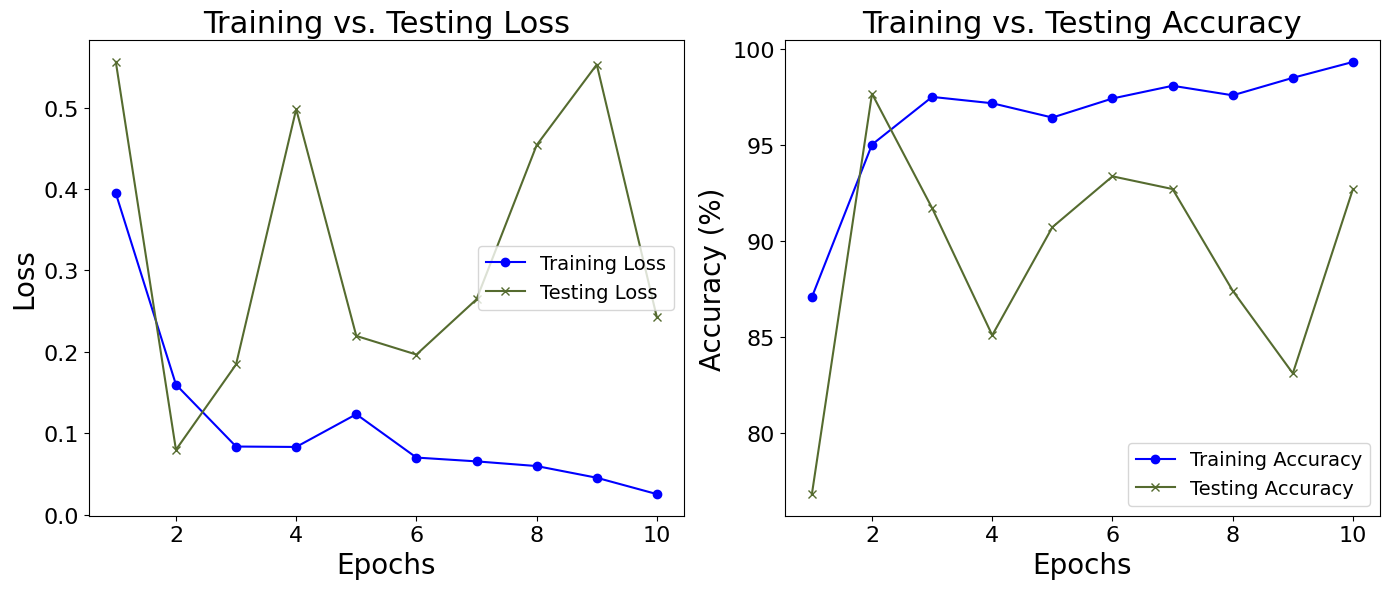

In [8]:
# Plot training and testing metrics
def plot_training_and_testing(training_loss, testing_loss, training_accuracy, testing_accuracy, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label="Training Loss", marker='o', color='blue')
    plt.plot(epochs, testing_loss, label="Testing Loss", marker='x', color='darkolivegreen')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.title("Training vs. Testing Loss", fontsize=22)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label="Training Accuracy", marker='o', color='blue')
    plt.plot(epochs, testing_accuracy, label="Testing Accuracy", marker='x', color='darkolivegreen')
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Accuracy (%)", fontsize=20)
    plt.title("Training vs. Testing Accuracy", fontsize=22)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_and_testing(training_loss, testing_loss, training_accuracy, testing_accuracy, num_epochs)

## Get Predictions for a Single Supplied Image

To get predictions for a single image, use the following function:

```python
prediction = get_prediction_and_display(test_image_path)
```

- **`test_image_path`**: The file path to the image you would like to get a prediction for.
- **`prediction`**: The output prediction generated by the model for the supplied image.


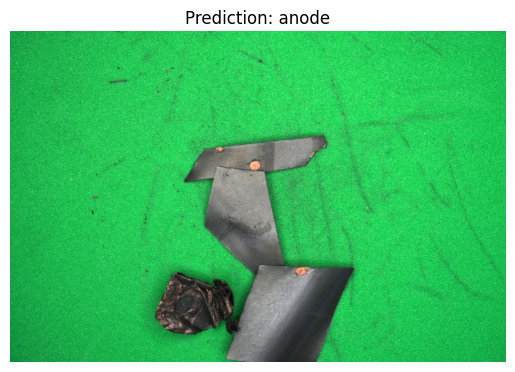

In [9]:
# Function to get raw predictions given a single image path and display the image
def get_prediction_and_display(model, image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    prediction = dataset.classes[predicted.item()]

    # Display the image and the prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {prediction}")
    plt.show()

    return prediction

# Get random image from the test set
test_image_path = test_dataset.dataset.imgs[np.random.randint(len(test_dataset))][0]

# Get the prediction and display the image
prediction = get_prediction_and_display(model, test_image_path)


## Get Predictions for a Set of Images

To get predictions for a set of images, use the following function:

```python
predict_and_display_grid(test_image_dirs, model, known_labels=True)
```

- **`test_image_dirs`**: A list of directories containing images you would like to get predictions for. If your images are labelled, have them in directory names `anodes`, `cathodes`, `nothing`.
- **`model`**: The saved model.
- **`known_labels`**: If your images are unlabeled, set this flag to `False` and it will provide raw predictions. Otherwise, the expectation is that you provide labeled directories for the grid visualization to indicate if the prediction is correct or not. 


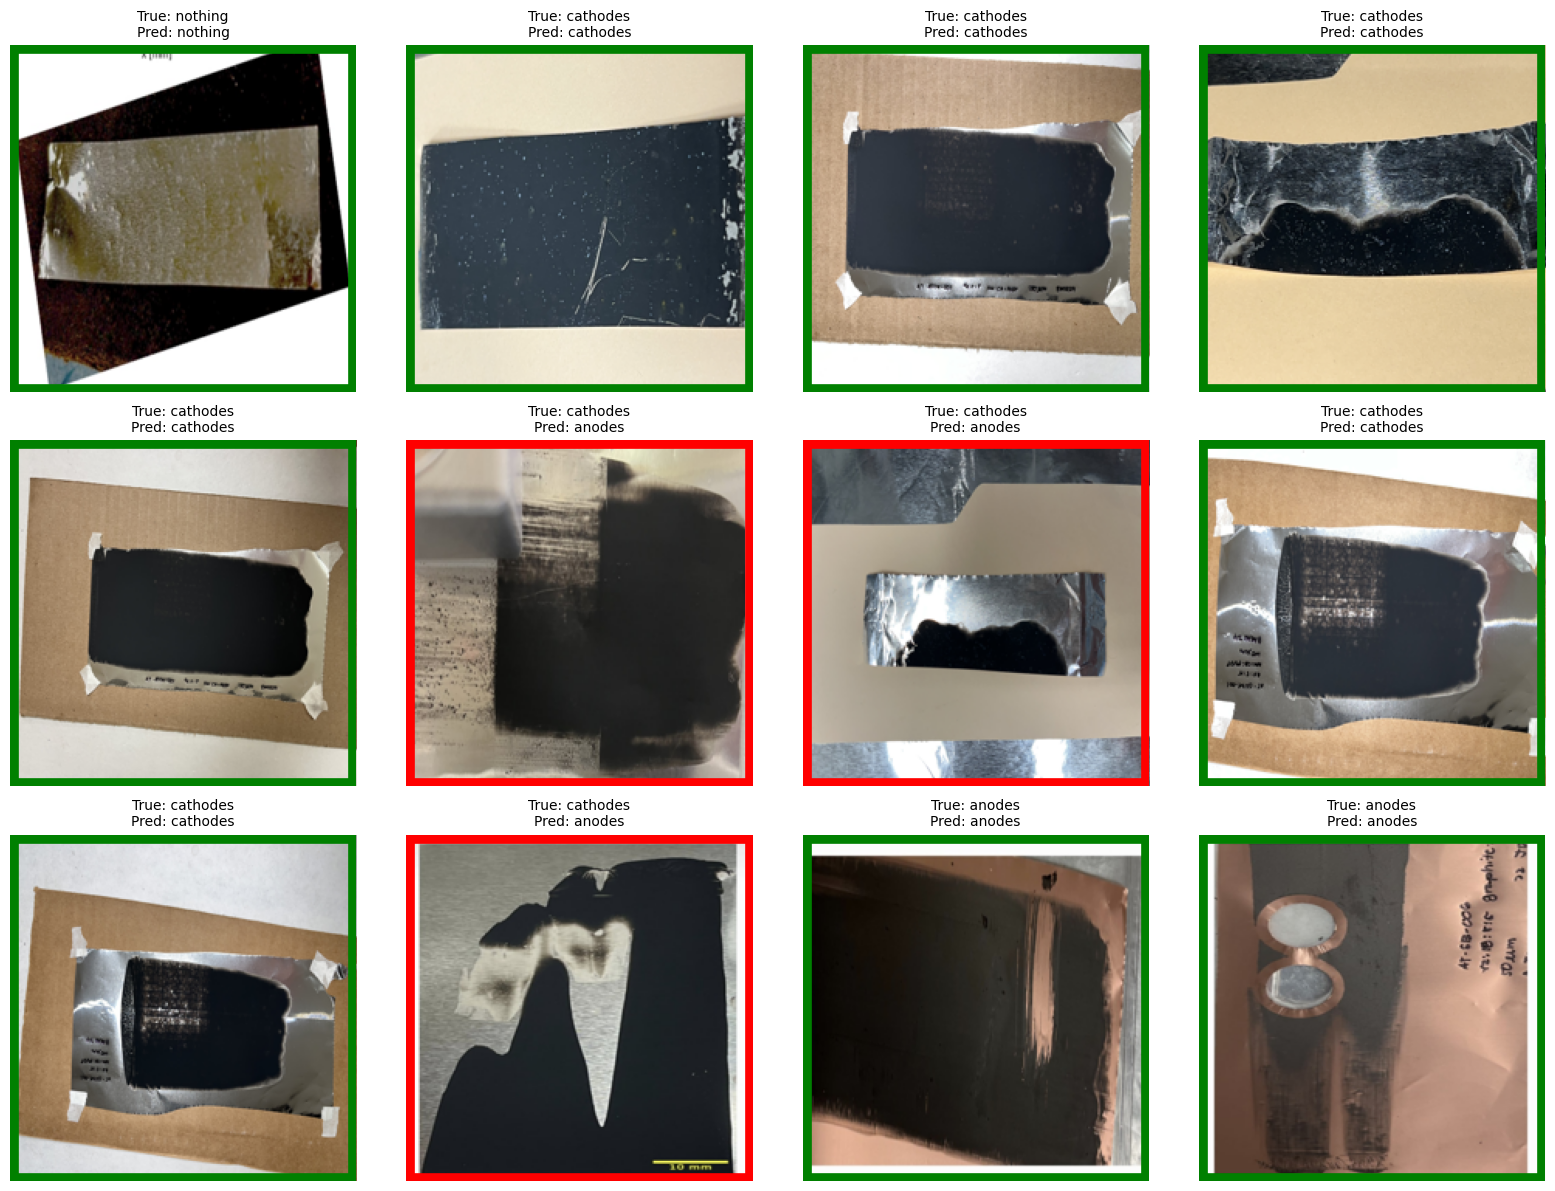

In [15]:
# Function to predict and display images in a grid
def predict_and_display_grid(image_dirs, model, known_labels=True):

    # Load images from directories
    images = []
    class_names = ['nothing', 'cathodes', 'anodes']

    for dir_path in image_dirs:
        label = os.path.basename(dir_path)
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            image = Image.open(img_path)
            images.append((image, label))

    # Set up the grid with more rows than columns
    num_images = len(images)
    grid_cols = 4  # Set a fixed number of columns
    grid_rows = (num_images + grid_cols - 1) // grid_cols  # Calculate the required number of rows

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))

    # Flatten axes for simpler indexing
    axes = axes.flatten()

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Predict and display each image
    for i, (image, true_label) in enumerate(images):
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = class_names[predicted.item()]

        # Resize the image to a consistent size for display
        image_resized = image.resize((224, 224))

        ax = axes[i]
        ax.imshow(image_resized)

        if known_labels:
            ax.set_title(f'True: {true_label}\nPred: {predicted_class}', fontsize=10)
            # Add an outline based on prediction correctness
            if true_label == predicted_class:
                rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='green', linewidth=12, fill=False)
            else:
                rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='red', linewidth=12, fill=False)
            ax.add_patch(rect)
        else:
            ax.set_title(f'Pred: {predicted_class}', fontsize=10)

        ax.axis('off')

    # Remove any unused subplots
    for j in range(len(images), len(axes)):
        fig.delaxes(axes[j])  # Completely remove unused axes

    plt.tight_layout()
    plt.show()


# Call the function to predict and display images in a grid
image_dirs = ['lab_electrode_images/nothing', 'lab_electrode_images/cathodes', 'lab_electrode_images/anodes']
predict_and_display_grid(image_dirs, model, known_labels=True)

In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pth")